In [1]:
import os
import sys

import numpy as np
import copy

from glob import glob
import argparse

import matplotlib
import matplotlib.pyplot as plt

In [2]:
MODEL = "model_rnn_LSTM.120_Dense.5010_LSTMKernelInit.VarianceScaling_DenseKernelInit.lecun_uniformKRl1.0_KRl2.0_recAct.sigmoid"
# MODEL = "model_rnn_GRU.120_Dense.5010_LSTMKernelInit.VarianceScaling_DenseKernelInit.lecun_uniformKRl1.0_KRl2.0_recAct.sigmoid"

model_name = 'Large LSTM Model'
# model_name = 'Large GRU Model'

fld = "/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/hls/projects/"

files_loc = f"{fld}/{MODEL}/reports/*.txt"

In [3]:
plot_loc = f'model_plots/{MODEL}'

if not os.path.exists(plot_loc):
    os.makedirs(plot_loc)

In [4]:
files = glob(files_loc)

In [5]:
files

['/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/hls/projects//model_rnn_LSTM.120_Dense.5010_LSTMKernelInit.VarianceScaling_DenseKernelInit.lecun_uniformKRl1.0_KRl2.0_recAct.sigmoid/reports/model_14.4.AP_TRN.AP_WRAP_reuse_2000_Resource.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/hls/projects//model_rnn_LSTM.120_Dense.5010_LSTMKernelInit.VarianceScaling_DenseKernelInit.lecun_uniformKRl1.0_KRl2.0_recAct.sigmoid/reports/model_24.10.AP_TRN.AP_WRAP_reuse_200_Resource.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/hls/projects//model_rnn_LSTM.120_Dense.5010_LSTMKernelInit.VarianceScaling_DenseKernelInit.lecun_uniformKRl1.0_KRl2.0_recAct.sigmoid/reports/model_18.10.AP_TRN.AP_WRAP_reuse_5000_Resource.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/hls/projects//model_rnn_LSTM.120_Dense.5010_LSTMKernelInit.VarianceScaling_DenseKernelInit.lecun_uniformKRl1.0_KRl2.0_recAct.sigmoid/reports/model_26.10.AP_TRN.AP_WRAP_reuse_2000_Resource.txt',
 '/gpfs/slac/atlas/fs1/d/r

In [6]:
base_dict = {
    'name':'',
    'BRAM_18K': -1,
    'DSP48E': -1,
    'FF': -1,
    'LUT': -1,
    'URAM':-1,
    'LAT_min':-1,
    'LAT_max': -1,
    'ap_tot': -1,
    'ap_int': -1,
    'ap_quant': '',
    'ap_over': '',
    'strategy': '',
    'reuse': -1,
    'keras_auc': -1,
    'hls_auc': -1,
    'rel_auc': -1
}

In [7]:
dicts = []

lat_unit = 'us'

for ff in files:
    with open(ff, 'r') as hf:

        this_dict = copy.deepcopy(base_dict)
        this_dict['name'] = ff.split('/')[-1].replace('.txt', '')
        
        this_dict['reuse'] = int(this_dict['name'].split('_reuse_')[-1].split('_')[0])
        this_dict['strategy'] = this_dict['name'].split('_reuse_')[-1].split('_')[1]

        modes = this_dict['name'].split('_reuse_')[0].replace('model_', '').split('.')

        this_dict['ap_tot'] = int(modes[0])
        this_dict['ap_int'] = int(modes[1])
        this_dict['ap_quant'] = modes[2]
        this_dict['ap_over'] = modes[3]

        for line in hf:
            if 'function' in line or 'none' in line or 'dataflow' in line:
                if '_' in line: continue
                
                sline = line.split()
                sline = [ sl.replace('|', '') for sl in sline ]

                this_dict['LAT_min'] = float(sline[3])
                this_dict['LAT_max'] = float(sline[6])
                
                # if sline[4] != sline[7]:
                #     print(sline[4], sline[7])
                #     break
                
                if 'ms' in sline[4]:
                    this_dict['LAT_min'] = this_dict['LAT_min']*1e3
                if 'ns' in sline[4]:
                    this_dict['LAT_min'] = this_dict['LAT_min']*1e-3
                    
                if 'ms' in sline[7]:
                    this_dict['LAT_max'] = this_dict['LAT_max']*1e3
                if 'ns' in sline[7]:
                    this_dict['LAT_max'] = this_dict['LAT_max']*1e-3
    
                # if 'none' in lat_unit:
                #     lat_unit = sline[4]
                # else:
                #     assert sline[4] == lat_unit

            if 'Total' in line and this_dict['FF'] == -1:
                sline = line.split()
                sline = [ sl.replace('|', '') for sl in sline ]
                
                this_dict['BRAM_18K']  = int( sline[2] )
                this_dict['DSP48E']    = int( sline[3] )
                this_dict['FF']        = int( sline[4] )
                this_dict['LUT']       = int( sline[5] )
                this_dict['URAM']      = int( sline[6] )
            
            if 'KERAS_AUC' in line:
                sline = line.split()
                this_dict['keras_auc'] = float(sline[1])

            if 'HLS_AUC' in line:
                sline = line.split()
                this_dict['hls_auc'] = float(sline[1])

        this_dict['rel_auc'] = abs( this_dict['keras_auc'] - this_dict['hls_auc'] ) / this_dict['keras_auc']
        dicts.append(this_dict)

In [8]:
tot_dict = copy.deepcopy(base_dict)

for kk in tot_dict:
    tot_dict[kk] = [ dd[kk] for dd in dicts]

In [9]:
import pandas as pd

In [10]:
pd_dict = pd.DataFrame.from_dict(tot_dict)

In [11]:
def get_plot(st, reu, apint, var):
    xi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) ].ap_tot.to_numpy()
    yi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) ][var].to_numpy()
    sort_i = xi.argsort()
    x = xi[sort_i]
    y = yi[sort_i]
    return [x,y]

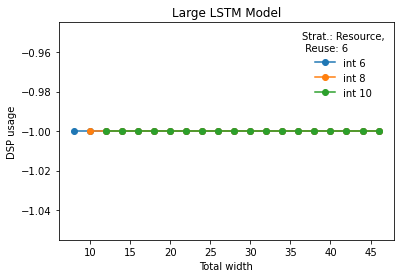

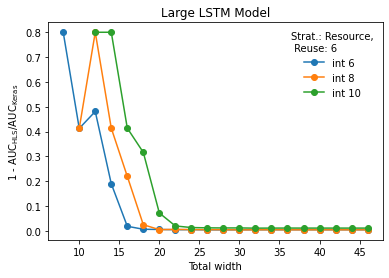

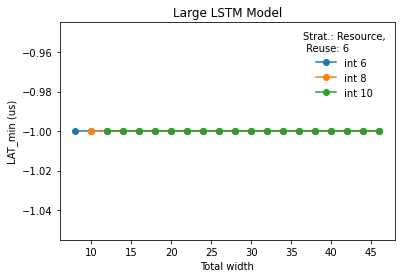

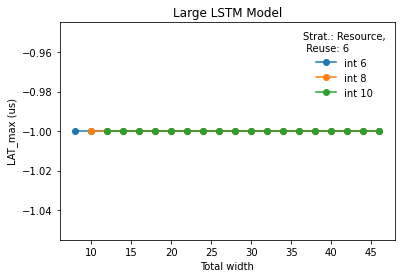

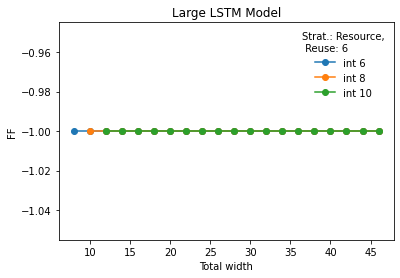

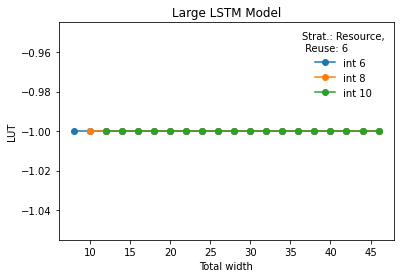

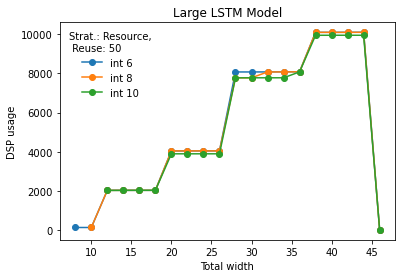

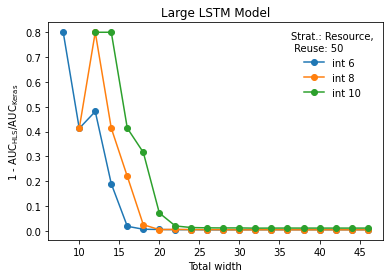

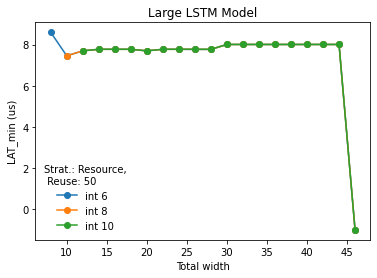

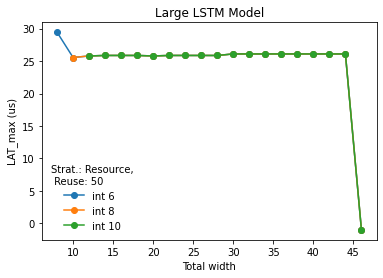

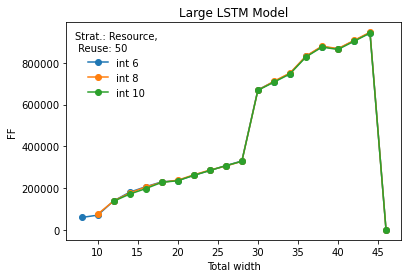

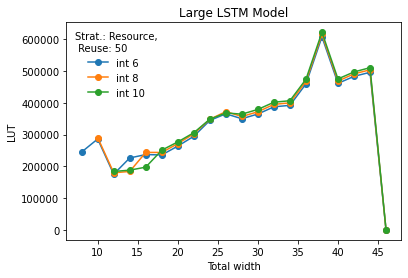

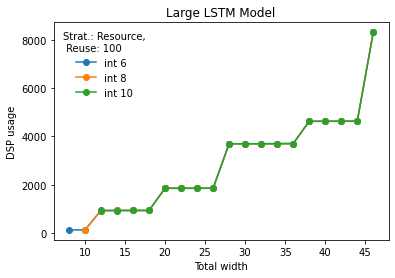

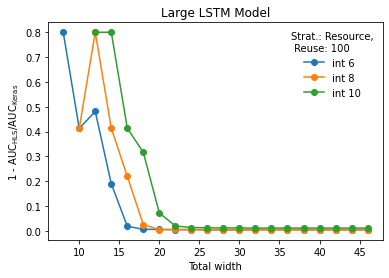

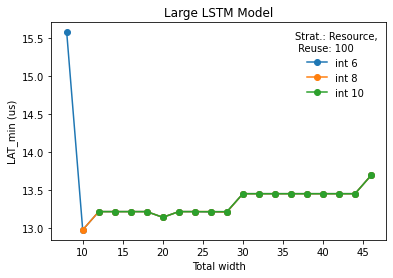

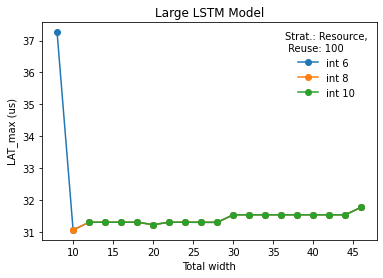

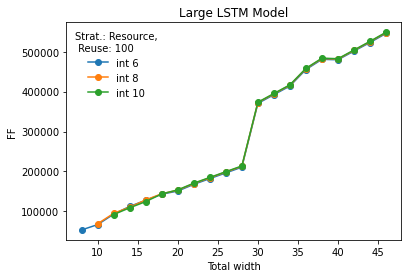

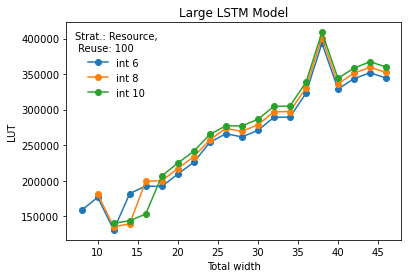

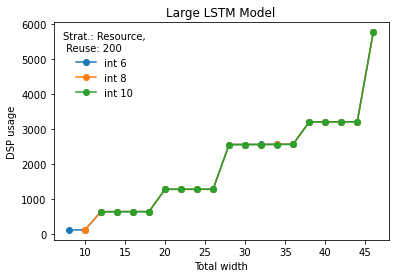

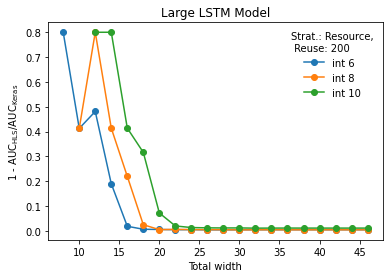

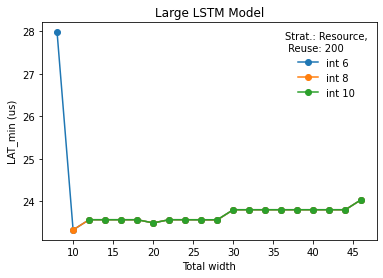

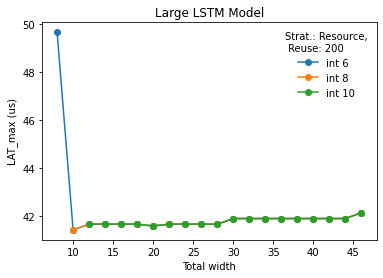

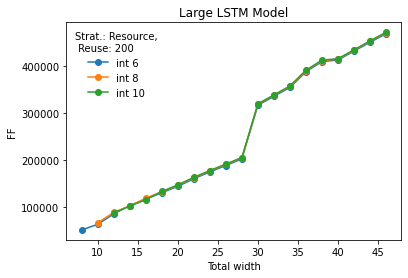

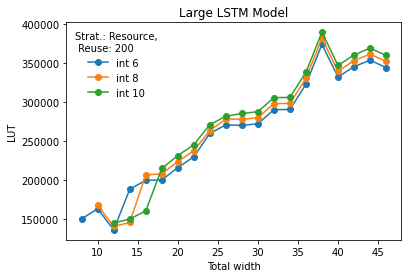

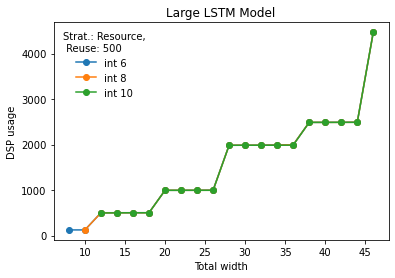

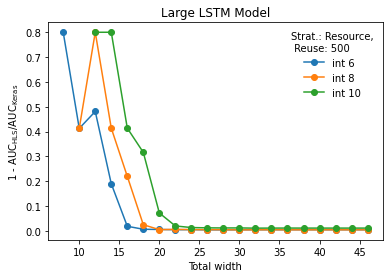

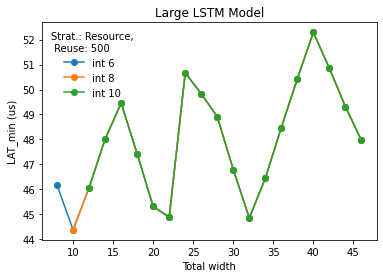

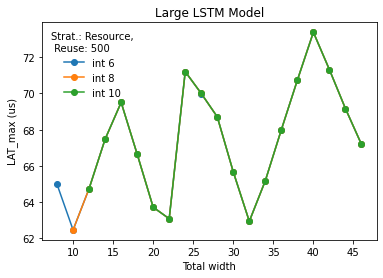

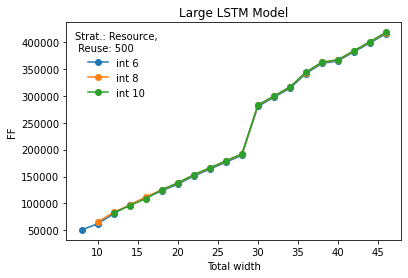

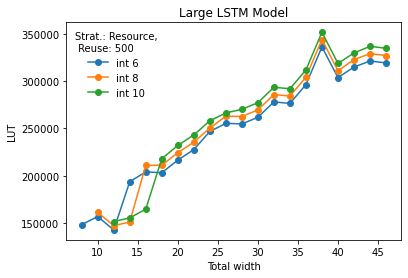

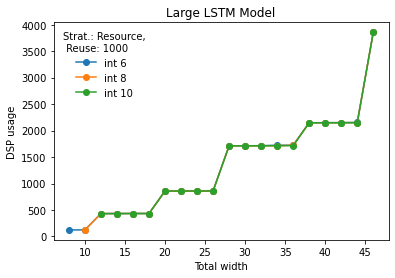

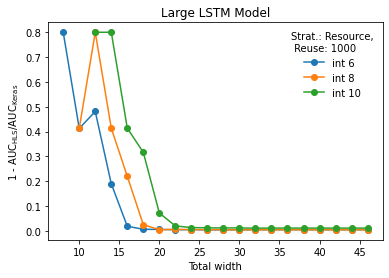

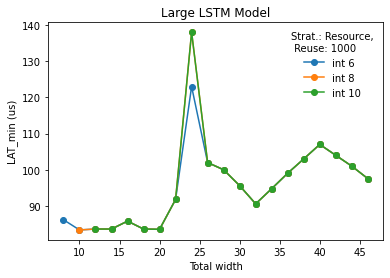

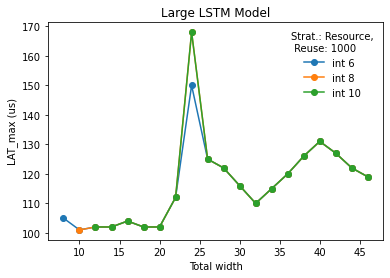

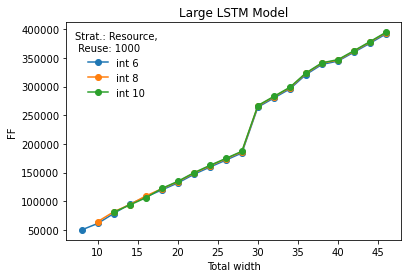

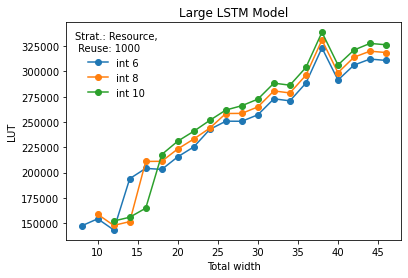

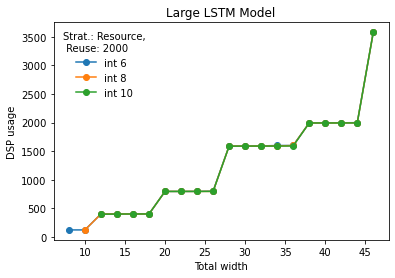

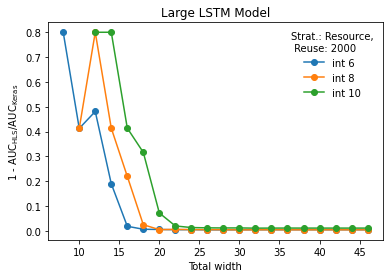

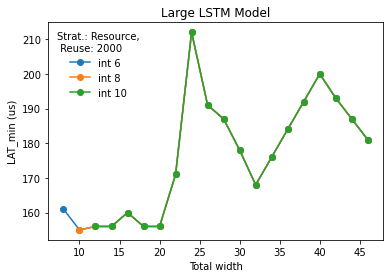

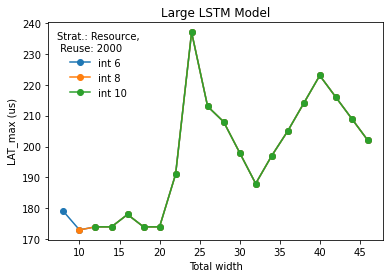

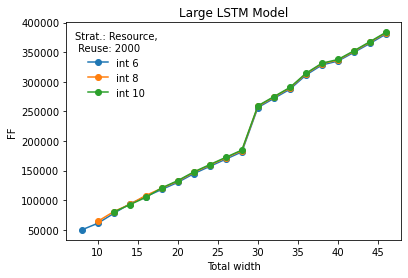

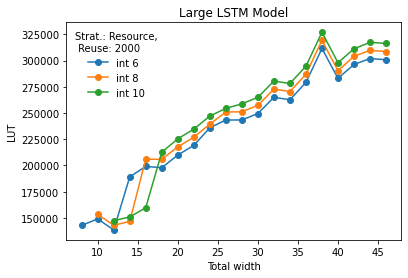

In [12]:
strat = 'Resource'
reuse = 5000

vars = ['DSP48E', 'rel_auc', f'LAT_min', f'LAT_max', 'FF', 'LUT']
var_labs = ['DSP usage', r'1 - $\mathrm{AUC_{HLS}/AUC_{Keras}}$', f'LAT_min', f'LAT_max', 'FF', 'LUT']

for reuse in [6, 50, 100, 200, 500, 1000, 2000]:
    
    for ivv,vv in enumerate(vars):

        plt.Figure()
        plt.title(model_name)

        # myplot = get_plot(strat, reuse, 4, vv)
        # plt.plot( myplot[0],myplot[1], 'o-', label='int 4' )

        myplot = get_plot(strat, reuse, 6, vv)
        plt.plot( myplot[0],myplot[1], 'o-', label='int 6' )

        myplot = get_plot(strat, reuse, 8, vv)
        plt.plot( myplot[0],myplot[1], 'o-', label='int 8' )

        myplot = get_plot(strat, reuse, 10, vv)
        plt.plot( myplot[0],myplot[1], 'o-', label='int 10' )

        plt.legend(title=f'Strat.: {strat},\n Reuse: {reuse}', frameon=False)
        # plt.legend(frameon=False)
        plt.xlabel('Total width')
        if 'LAT' in vv:
            plt.ylabel(var_labs[ivv]+f' ({lat_unit})')
        else:
            plt.ylabel(var_labs[ivv])

        plt.savefig(f"{plot_loc}/{vv}_{reuse}.pdf")
        plt.show()

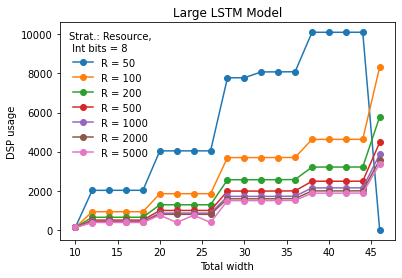

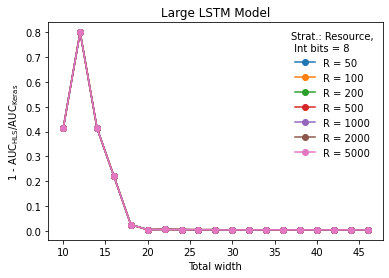

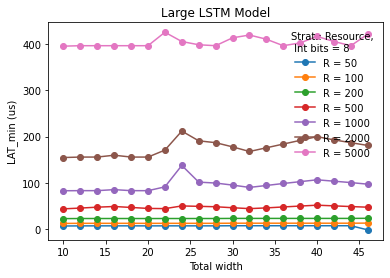

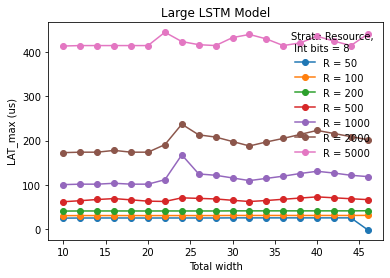

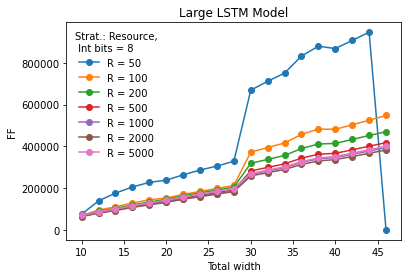

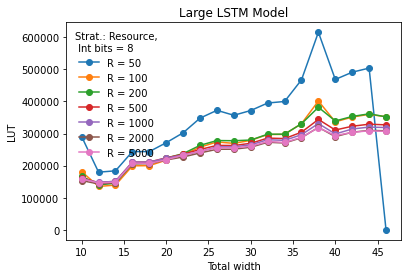

In [13]:
strat = 'Resource'

vars = ['DSP48E', 'rel_auc', f'LAT_min', f'LAT_max', 'FF', 'LUT']
var_labs = ['DSP usage', r'1 - $\mathrm{AUC_{HLS}/AUC_{Keras}}$', f'LAT_min', f'LAT_max', 'FF', 'LUT']

    
for ivv,vv in enumerate(vars):

    plt.Figure()
    plt.title(model_name)

    for reuse in [50, 100, 200, 500, 1000, 2000, 5000]:
        myplot = get_plot(strat, reuse, 8, vv)
        plt.plot( myplot[0],myplot[1], 'o-', label=f'R = {reuse}' )


    plt.legend(title=f'Strat.: {strat},\n Int bits = 8', frameon=False)
    # plt.legend(frameon=False)
    plt.xlabel('Total width')
    if 'LAT' in vv:
        plt.ylabel(var_labs[ivv]+f' ({lat_unit})')
    else:
        plt.ylabel(var_labs[ivv])

    plt.savefig(f"{plot_loc}/{vv}_reuseScan.pdf")
    plt.show()